<a href="https://colab.research.google.com/github/BumaranChe/Simple-Time-Series-Forecasting-Using-RNN/blob/main/Simple_RNN_for_time_series_forcasting(temp)_Bumaran_(GitHub).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [ ]:
import os
os.environ["TF_DETERMINISTIC_OPS"]="1"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential#T o deal with sequential data
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split

#Create a simple dummy time series data

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
days = np.arange(400) # 400 points/days
temp = 28 + 3*np.sin(2*np.pi*days/30) # base signal
temp += 0.8*np.random.randn(len(days)) # noise
df = pd.DataFrame({"day": days, "temp": temp}) # data frame

print("Normal DF (head):")
print(df.head()) # print data frame

Normal DF (head):
   day       temp
0    0  28.397371
1    1  28.513124
2    2  29.738361
3    3  30.981780
4    4  30.042112


In [ ]:
temp

array([28.39737132, 28.51312363, 29.73836076, 30.98177964, 30.04211178,
       30.41076665, 32.1165398 , 31.59751347, 30.60798618, 31.28721758,
       30.22734206, 29.85685067, 29.95692557, 27.68958573, 27.24380081,
       27.55016998, 26.56600003, 27.03118794, 25.51022498, 24.64072256,
       26.5744428 , 24.96620941, 25.07045688, 23.87663576, 24.71132427,
       25.49066186, 24.84977066, 26.53720266, 26.29927912, 27.14290993,
       27.51863471, 30.10555762, 29.20941215, 28.91718701, 30.88747041,
       29.62140129, 31.02026042, 29.41582959, 29.92101685, 31.01065854,
       31.18884948, 30.3665291 , 29.67083713, 28.97932697, 27.44091748,
       27.42412463, 27.00775391, 27.62548785, 26.51153887, 24.3601334 ,
       25.66119096, 24.83876463, 24.47489671, 25.50577534, 25.97163007,
       26.14694788, 25.0991915 , 25.98927434, 27.04480082, 28.15670103,
       27.61666061, 28.47520789, 28.33514195, 28.80639046, 30.87945513,
       31.68306823, 30.79556145, 31.786392  , 31.27287451, 30.33

# Double confirm whether its 1D array or 2D array

In [ ]:
print(days.shape)

(400,)


In [ ]:
print(temp.shape)

(400,)


In [ ]:
print(df.shape) # size of the data frame
print(df.ndim) # number of dimension (coloumns + rows)

(400, 2)
2


df is 2D array

#Plot the time series data

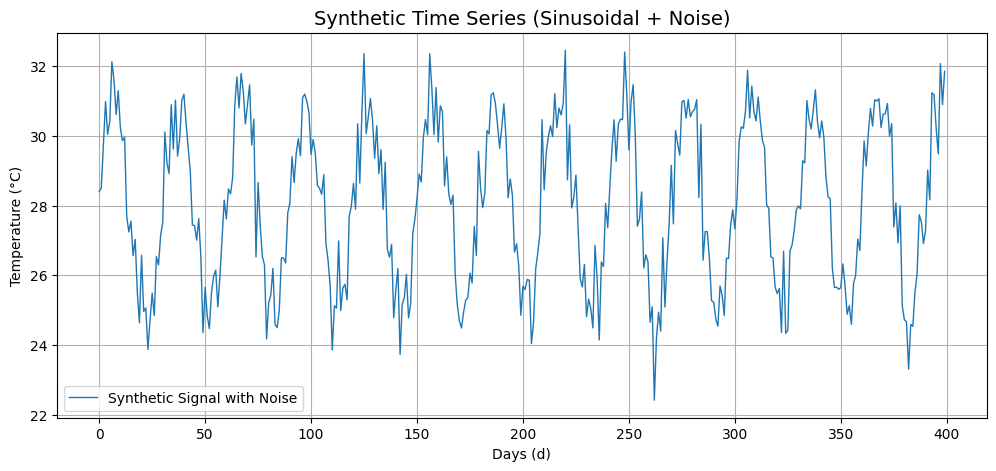

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(days,temp,label = "Synthetic Signal with Noise",linewidth = 1)
plt.title("Synthetic Time Series (Sinusoidal + Noise)", fontsize=14)
plt.xlabel("Days (d)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

#Before we use this data , we need to scale it to 0-1 to help on the training and also remove bias in the data


* Once the data is scaled , it will work better when input are in a small and consistent range. 0 - 1 .
* Prevent large values from dominating gradient updates . (Bias).

##Example
Suppose your raw series ranges from -3.5 to +4.2.
* -3.5 -> 0
* 4.2 -> 1
* Everything else -> Propotionally between 0 - 1

In [ ]:
scaler = MinMaxScaler()
temp_scaled = scaler.fit_transform(df[['temp']].values) # we only select one column which is temp (400,1)
#converts your 1D array into a 2D column vector because scikit-learn expects input as (n_samples, n_features).
#fit_transform() learns the min and max of your data, then transforms each value.
#flatten() -> makes it 1D again so you can work with it like your original series.

#By now you should know that , RNN gets the input data in sequence .

* In this case we need to convert the continous series into (input-> output) sequence.

* Since its a supervised, we need to tune the data in a way that it shows the input sequence and the required output based on the sequential data.

* Normally this is done for timeseries or sequential data.

If series = [10, 20, 30, 40, 50] and window=3:

Iteration 0:

X[0] = [10, 20, 30]

y[0] = 40

Iteration 1:

X[1] = [20, 30, 40]

y[1] = 50

In [ ]:
#arr -> your time series data (already scaled usually).
#win = 30 -> sliding window size (monthly = 30 days, often used for “last 30 days” in monthly data).
def make_sequence(arr,win=30):
  X,y = [],[]#We create an empty list first for X to hold the input values , y to hold the target prediction.
  for i in range(len(arr)-win):
    X.append(arr[i:i+win]) # 0:29 -> [0,1,2,3,4,5,6,7,8,9,10...29],[1,2,3,....30],[2,3,4,....31],.........[368,340,341,......398]-> Input, the shape is (30,1)
    y.append(arr[i+win])#0+30 -> [30],[31],[32],..........[399]-> Output, the shape is (1,)
  X = np.array(X) # after the loop turns python list of 370 elements from 2D array (win(timesteps per window)), 1 (temp/feature)) into 3D array (samples, win, 1 (temp)). np.array(X) stacks them together and the shape becomes (370,30,1) --> 3D
  y = np.array(y).flatten() # after the loop the shape becomes (270,1) and after flatten becomes (270,) --> 1D
  return X,y

note: arr is 400,1 --> it's 2D array from Data Frame (df)

#Using the function created , we create the input features and the output labels with the time series data.

In [ ]:
X,y = make_sequence(temp_scaled) # keep the array returned by the function

In [ ]:
print(type(X))

<class 'numpy.ndarray'>


In [ ]:
print(type(y))

<class 'numpy.ndarray'>


X and y converted from python list to Numpy array

In [ ]:
len(X[0])#Mean you have 30 sequence of data

30

In [ ]:
X[0].shape # 2 dimensional 30 rows/timesteps per window, 1 feature (temp)

(30, 1)

In [ ]:
X[1].shape # 2 dimensional 30 rows/timesteps per window, 1 feature (temp)

(30, 1)

In [ ]:
X[2].shape # 2 dimensional 30 rows/timesteps per window, 1 feature (temp)

(30, 1)

In [ ]:
print(X.shape) # 3 dimensional array 370 (samples), 30 timesteps / window, 1 feature per timestep

(370, 30, 1)


X is 3D numpy array, RNN only accepts 3D input

In [ ]:
X.shape[0]

370

In [ ]:
X.shape[1]

30

In [ ]:
X.shape[2]

1

In [ ]:
y

array([0.50818071, 0.7661923 , 0.67681356, 0.64766794, 0.84417783,
       0.71790407, 0.85742189, 0.69740099, 0.74778678, 0.85646423,
       0.87423644, 0.79222078, 0.72283464, 0.65386558, 0.50042944,
       0.49875457, 0.45722706, 0.51883791, 0.40773613, 0.19316168,
       0.32292509, 0.24089886, 0.20460782, 0.30742442, 0.35388732,
       0.37137296, 0.26687303, 0.3556471 , 0.460922  , 0.57181945,
       0.51795751, 0.60358633, 0.58961659, 0.63661744, 0.84337842,
       0.92352827, 0.83501112, 0.93383346, 0.88261683, 0.78928299,
       0.84415014, 0.90126655, 0.72920362, 0.80273262, 0.40937182,
       0.62176976, 0.50092664, 0.41063302, 0.38764054, 0.17524665,
       0.27953909, 0.30011822, 0.3765395 , 0.21726656, 0.20711509,
       0.25703165, 0.40687324, 0.40654988, 0.39222136, 0.53493455,
       0.56393635, 0.69568766, 0.62187403, 0.70591816, 0.74726128,
       0.69854145, 0.86438406, 0.87459154, 0.85417008, 0.82203919,
       0.70238285, 0.74498431, 0.70471714, 0.6138772 , 0.60553

In [ ]:
len(y)

370

In [ ]:
print(y.shape)

(370,)


y is 1D numpy array because it was flatten in funtion "make_sequence"

We have total 370 y outputs (labels / target value) because ( 400 days - 30 Window size = 370 number of sequence )

#Train validation split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # no shuffle for time-series
)

#Build the RNN Model

In [ ]:
model = Sequential([
    SimpleRNN(32,input_shape = (30,1)),
    Dense(1)
])
#Sequential :  This line initializes a Sequential model, which means layers are added one after another in a linear stack.
#32 is the number of unit(neurons in this layer. This will deterimine the dimension of the output space of the layer
#input_shape = (30,1)-> Specifies the shape of the input data that the first layer expects.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#Compile the function

In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = optimizer,loss = 'mse')

Train the model

In [ ]:
history = model.fit(X_train,y_train,epochs=20,batch_size=32,validation_data=(X_test,y_test),verbose=0,shuffle=False)

#Validation data ->After each epoch, the model will evaluate itself on (X_test,y_test.)This will help you to monitor the overfitting.

In [ ]:
history.history

{'loss': [0.09908302873373032,
  0.05023373290896416,
  0.04210851714015007,
  0.02968996949493885,
  0.023614956066012383,
  0.018346339464187622,
  0.014466682448983192,
  0.012509791180491447,
  0.011428052559494972,
  0.010727343149483204,
  0.010151827707886696,
  0.009710884653031826,
  0.009420961141586304,
  0.009168789722025394,
  0.008934887126088142,
  0.008729036897420883,
  0.008541248738765717,
  0.008375846780836582,
  0.008234047330915928,
  0.008107372559607029],
 'val_loss': [0.05555056408047676,
  0.05133325606584549,
  0.031161321327090263,
  0.0245294701308012,
  0.019614674150943756,
  0.01417097169905901,
  0.011922011151909828,
  0.010566003620624542,
  0.010171040892601013,
  0.009542787447571754,
  0.009007556363940239,
  0.008703001774847507,
  0.008494343608617783,
  0.008249124512076378,
  0.008004020899534225,
  0.0077998703345656395,
  0.007611799985170364,
  0.007451261393725872,
  0.007317574229091406,
  0.007202002685517073]}

#Evaluate the model

In [ ]:
print(f"Final val MSE: {history.history['val_loss'][-1]:.4f}")

Final val MSE: 0.0072


MSE value near to zero indicates Predictions are very accurate (errors are very small)

# Plot training and validation loss / metrics

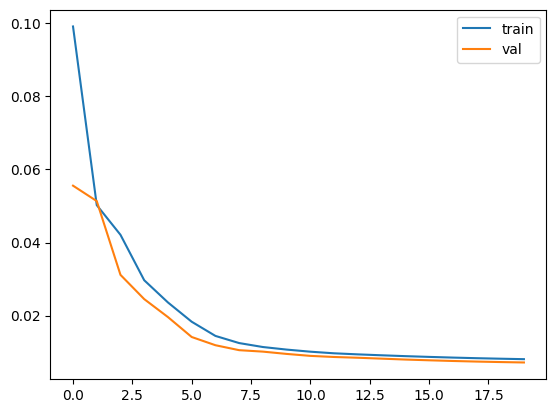

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

It is normal for the plot looks different in the beginning because at the beginning the model is untrained, so it has no knowledge of patterns in either train set or val set. As training progresses Training loss decreases and Validation loss decreases. Eventually, if model is stable, train and val curves converge.

#Create the forcast from the last window

In [ ]:
def forcast_multi(last_window_scaled,d):
  preds_scaled = []# store scaled predictions
  w = last_window_scaled.copy()# start with the last input window

  for _ in range(d):
    x = w.reshape(1,30,1)# shape: (batch=1, timesteps=30, features=1)
    next_scaled = float(model.predict(x,verbose=0)[0,0])
    preds_scaled.append(next_scaled)# save prediction into the empty array created
    w = np.append(w[1:],next_scaled) #slide window forward (drop oldest, add newest)
  preds = scaler.inverse_transform(
      np.array(preds_scaled).reshape(-1, 1)
    ).flatten()
  return preds

In [ ]:
d = 50
last_window_scaled = X_test[-1].flatten()
future = forcast_multi(last_window_scaled,d) # future becomes preds ( the return of function forecast_multi)

In [ ]:
future#Future predicted values

array([30.35948847, 30.65176419, 29.78779062, 29.50346921, 29.28550382,
       28.77556989, 27.88304687, 27.54738222, 27.04339341, 26.21633895,
       25.90802433, 25.63618091, 25.15346045, 24.87889891, 25.06104346,
       25.16275642, 25.15324262, 25.88467327, 26.47523944, 26.82053054,
       27.51909034, 28.376566  , 28.67478803, 29.16551209, 30.10421493,
       30.37427774, 30.52540901, 30.94358153, 31.12329034, 31.00543988,
       30.93181023, 30.68420354, 30.20655299, 29.88446146, 29.46642819,
       28.84936508, 28.36304009, 27.9033946 , 27.28381731, 26.73444143,
       26.35878681, 25.93384027, 25.53605194, 25.36233725, 25.29532384,
       25.2457899 , 25.40655149, 25.7877562 , 26.16364718, 26.64439967])

#Plot the values

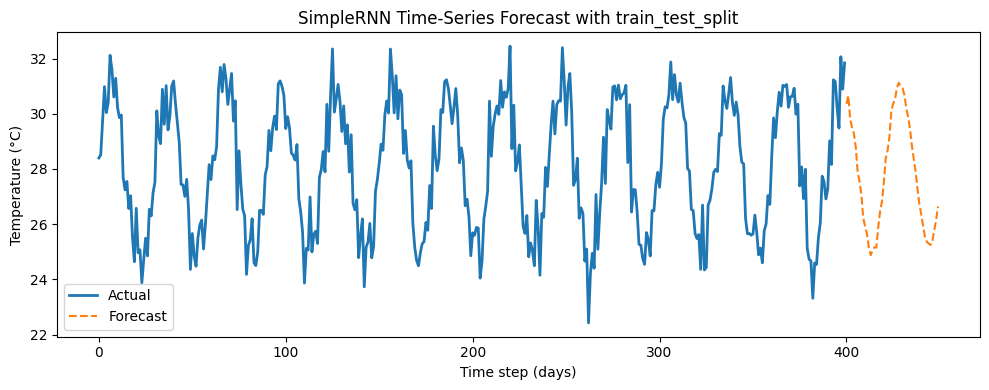

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(temp, label="Actual", linewidth=2)
plt.plot(np.arange(len(temp), len(temp)+d), future, "--", label="Forecast")
plt.title("SimpleRNN Time-Series Forecast with train_test_split")
plt.xlabel("Time step (days)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# length of real + predicted
n_real = len(temp)        # 400
n_pred = len(future)      # 50

# create full index (day numbers)
days = np.arange(1, n_real + n_pred + 1)  # 1 to 450

# build DataFrame
df = pd.DataFrame({
    "Day": days,
    "Temperature": np.concatenate([temp, future]),
    "Type": ["Real"] * n_real + ["Predicted"] * n_pred
})

print(df.to_string())

     Day  Temperature       Type
0      1    28.397371       Real
1      2    28.513124       Real
2      3    29.738361       Real
3      4    30.981780       Real
4      5    30.042112       Real
5      6    30.410767       Real
6      7    32.116540       Real
7      8    31.597513       Real
8      9    30.607986       Real
9     10    31.287218       Real
10    11    30.227342       Real
11    12    29.856851       Real
12    13    29.956926       Real
13    14    27.689586       Real
14    15    27.243801       Real
15    16    27.550170       Real
16    17    26.566000       Real
17    18    27.031188       Real
18    19    25.510225       Real
19    20    24.640723       Real
20    21    26.574443       Real
21    22    24.966209       Real
22    23    25.070457       Real
23    24    23.876636       Real
24    25    24.711324       Real
25    26    25.490662       Real
26    27    24.849771       Real
27    28    26.537203       Real
28    29    26.299279       Real
29    30  